# Modeling Antibiotic Responce Through Datamining in the MIMICIII Dataset
###Garrett Eickelberg with help from Kishore Anekalla, Yikuan Li, Dr. Yuan Luo, Dr. Nelson Sanchez-Pinto

the streamlined version of "rotation_cohort_generation" has lots of debugging, older code, and non-utilized code removed to allow for top to bottom running. 

the overarching contents of this notebook will be detailed in my googledoc labnotebook 
https://docs.google.com/document/d/1bJcv0ZUkjVhFga9ZOLMNV6pXR9jLEMQmPhLS93njrCc/edit#

## changelog (starting 8/16/18)

-need to update cohort so that each hadm_id is treated as a new patient (rather than new patient). ie make a by hadm id vs by patient final cohort. for each hadmid, only the first associated icustay id meeting our criteria should be used.
-changing code in t_end_consec_annotation to drop duplicate data for each hadm_id rather htan each patient.


In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import collections
import asyncio
import getpass
import re
from datetime import datetime as dt
import os,sys,re
import urllib3
import prettytable
from collections import Counter
import seaborn as sns
import random
from datetime import timedelta

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

#reserach question:
-Can we predict the 5/7 day ab course by 48 hours after culture/ab start for icu patients?

#cohort criteria:
- YES- only adult patients (over 18 yo)  (~n= 38,000 age >18)
- with sterile culture 
- and ab start within the same 24 hours time window (bulk will be in first 24 hours but possibly not). 


Three subsets:
– Started on antibiotics, after 48hrs, negculture, discontinue	: neg/stop
- 48hrs, negculture, but continue full course 7, 10, or 14 days: neg/continue
– Positive culture, continue full course.Predict whether kept on antibiotics:

    pos/continue
    
	Infected with positive culture
    
	Infected with negative culture (ie a false positive)
    
    
#components: data cleaning, model building

In [2]:
#code used to ping the postgres mimic server. 

conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
                        password=getpass.getpass(prompt='Password:'.format()))
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

Password: ·····


time: 3.52 s


# importing prescription table annotated with RXCUI and ATC codes to id AB

In [3]:
#this code takes a while to run, only run if need to update prescription table (which is saved in github)
# #some rows in AB have the same drug name, but differing true/false ab status. this is updating any antibiotic row as true.

# #input: imported prescription df annotated with atc codes. 
# #ouput: updated prescription df where more true antibiotics are covered

# @memory.cache
# def prescription_update_fxn(prescription_df):
#         drugs_that_dont_belong =['Furosemide','Dextrose 50%','Vancomycin Oral Liquid',
#                          'Erythromycin 0.5% Ophth Oint','NEO*IV*Furosemide',
#                          'Nystatin','Orthopedic Solution','Neomycin-Polymyxin-Bacitracin Ophth. Oint',
#                          'Bacitracin Ophthalmic Oint','Bacitracin Ointment','Lasix',
#                          'dextrose','MetronidAZOLE Topical 1 % Gel','Enalaprilat',
#                          'NEO*PO*Furosemide (10mg/1ml)','Metronidazole Gel 0.75%-Vaginal','Spironolactone',
#                          'Heparin',
#                         'voriconazole','valgancyclovir','chloroquine','tamiflu','mefloquine','foscarnet',
#                          'fluconazole','vorconazole','quinine','ribavirin','gancyclovir','chloroquine',
#                          'atovaquone','ambisome', 'acyclovir', 'Acyclovir']

#     drugs_that_dont_belong=[w.lower() for w in drugs_that_dont_belong]
    
#     prescriptions= prescription_df
#     prescriptions_updated = list(prescriptions.loc[prescriptions.loc[:,"Antibiotics"]==True,'drug'].unique()) 
#     true_ndc= prescriptions.loc[prescriptions.loc[:,"drug"].isin(prescriptions_updated),'ndc'].unique() 

#     ABrx2= prescriptions.loc[prescriptions.loc[:,"ndc"].isin(true_ndc),:]
#     ABrx2= ABrx2.loc[~ABrx2.loc[:,"drug"].str.lower().isin(drugs_that_dont_belong),:] #tilde transforms isin to notin()
#     ABrx2['Antibiotics']= True
#     return(ABrx2)



time: 4.6 ms


In [4]:
#this code takes a while to run, only run if need to update prescription table (which is saved in github)
# #note shown: imported antibiotic annotations into prescription table using code provided by
# #Dr. Luo's postdoc, which pings API
# dtype = {'icustay_id': str,
#          'NDC': str,
#          'rxcui': str,
#          'ingredient': str}
# prescriptions = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/project/Newprescription.csv', index_col=0, dtype=dtype)

# #problem: some rows in AB have the same drug name, but differing true/false ab status. this is updating any antibiotic row as true.


# ABrx = prescription_update_fxn(prescriptions)
# ABrx = ABrx.loc[ABrx['Antibiotics'] == True, :]
# pd.DataFrame(ABrx).to_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/02082018_ABrx_updated.csv')


time: 2.11 ms


In [5]:
ABrx = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/02082018_ABrx_updated.csv')



time: 759 ms


In [6]:
#adjusting the antibiotic start time.
#antibiotics listed in the ABrx table have date but not time resolution for starting. given that 00:00:00 is not a likely starttime for antibiotics, 
#we are chainging the ABrx start time to be on XX:XX:XX for every date. 

time: 792 µs


In [7]:
len(ABrx) #156598
ABrx['drug'].unique()

array(['Daptomycin', 'Ceftazidime', 'Vancomycin HCl',
       'Sulfameth/Trimethoprim SS', 'NEO*IV*Gentamicin', 'Cefepime',
       'Gentamicin Sulfate', 'Vancomycin', 'Levofloxacin',
       'Bacitracin/Polymyxin B Sulfate Opht. Oint', 'CefTRIAXone',
       'Sulfameth/Trimethoprim DS', 'Ciprofloxacin HCl', 'Metronidazole',
       'Azithromycin ', 'Cefazolin', 'Ceftriaxone', 'Imipenem-Cilastatin',
       'CeftazIDIME', 'CeftriaXONE', 'Clindamycin',
       'Piperacillin-Tazobactam Na', 'Ampicillin Sodium', 'CefazoLIN',
       'Cephalexin', 'Linezolid', 'Ampicillin', 'Ciprofloxacin IV',
       'MetRONIDAZOLE (FLagyl)', 'Nystatin Oral Susp.',
       'Nystatin Oral Suspension', 'Amoxicillin-Clavulanic Acid',
       'Ciprofloxacin 0.3% Ophth Soln', 'Unasyn',
       'Gentamicin Sulfate Ophth.', 'NEO*IV*AMPicillin Sodium',
       'NEO*IV*Ampicillin Sodium', 'Gentamicin', 'Azithromycin',
       'Aztreonam', 'Meropenem', 'NEO*IV*Vancomycin', 'Ciprofloxacin',
       'CefePIME', 'Piperacillin-Tazoba

time: 18.7 ms


# generating patient culture/icu/hospital info


## sterile culture info

In [8]:
#retrieving all patients with sterile culture

##changed on 4/16/18 to include all hadm_id
sterile_pt_sql = query_schema + """
SELECT row_id, subject_id, hadm_id, chartdate, charttime, spec_itemid, spec_type_desc, org_name FROM mimiciii.microbiologyevents
WHERE NOT lower(spec_type_desc) = 'fluid received in blood culture bottles' AND
NOT lower(spec_type_desc) = 'blood bag fluid'
AND (lower(spec_type_desc) LIKE '%blood%' 
OR lower(spec_type_desc) LIKE '%joint%' 
OR lower(spec_type_desc) LIKE '%urine%' 
OR lower(spec_type_desc) LIKE  '%csf%'
OR lower(spec_type_desc) LIKE '%spinal%'
OR lower(spec_type_desc) LIKE '%pleural%'
OR lower(spec_type_desc) LIKE '%peritoneal%'
OR lower(spec_type_desc) LIKE '%bal%'
OR lower(spec_type_desc) LIKE '%bronchoalveolar lavage%')  --bal and bronchoalveolar lavage added 7/16/18

group by subject_id, row_id
ORDER BY count(subject_id) DESC
"""

sterile_pt_df=pd.read_sql_query(sterile_pt_sql,conn) #361711 patients with sterile culture -> 374643 with addn of bal and broncho... 7/16/18


time: 1min 5s


In [9]:
#a more detailed patient/admission/age data query

pt_age_admin_sql = query_schema + """
select p.subject_id, c.hadm_id, c.admittime, c.dischtime, c.admission_location, c.admission_type, p.first_admit_age, p.dob, p.gender from mimiciii.admissions c
join (SELECT
      p.subject_id, p.dob, p.gender, MIN( ROUND( (cast(admittime as date) - cast(dob as date)) / 365.242,2) )
          AS first_admit_age
  FROM mimiciii.patients p
  INNER JOIN mimiciii.admissions a
  ON p.subject_id = a.subject_id
  GROUP BY p.subject_id, p.dob, p.gender
  ORDER BY p.subject_id) p on c.subject_id = p.subject_id
"""
pt_age_admin_df = pd.read_sql_query(pt_age_admin_sql,conn) #38637
pt_age_admin_16_df= pt_age_admin_df.loc[pt_age_admin_df.loc[:,'first_admit_age']>16,:]
pt_age_admin_16_df = pt_age_admin_16_df.rename(index=str, columns={"admittime":'hosp_admit','dischtime':'hosp_disch'})

pt_source_sql = query_schema + """
SELECT subject_id, icustay_id, hadm_id, dbsource, intime, outtime, los, FIRST_WARDID, LAST_WARDID from mimiciii.icustays
"""
pt_source_df =pd.read_sql_query(pt_source_sql,conn) #46520 patients total, no ab, culture or age restrict
pt_source_df = pt_source_df.rename(index=str, columns={"intime":'ICU_admit','outtime':'ICU_disch'})

#merging icu info with patient admiin info- has all icustay id's with patient and admission info.
pt_icu_hosp_db_16 =pd.merge(pt_age_admin_16_df,pt_source_df.drop(['subject_id'], axis=1), left_on= 'hadm_id', right_on='hadm_id', how = 'right')
# len(pt_source_df) #61532
# len(pt_age_admin_16_df)#50857
# len(pt_icu_hosp_db_16) #61532



time: 7.55 s


In [10]:
# pt_age_admin_df

# from pathlib import Path
# os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
# wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'


# date= '22112018'
# pd.DataFrame(pt_age_admin_df).to_csv(Path(
#     wd+'/data/processed/%s_pt_age.csv' %(date)))

time: 2.49 ms


### mergeing sterile_pt_df with pt_icu_hosp_db_16
   - sterile_all_pt_info:
    is all the hospital, icu admission, and patient data for patients >=16yo w/ a sterile site culture.
   - merging dfs to concat all the hospital, icu admission, and patient data for patients >=16yo w/ a sterile site culture.

In [11]:
#merging dfs to concat all the hospital, icu admission, and patient data for patients >=16yo w/ a sterile site culture.

sterile_all_pt_info= None
#filtering and merging patient/hospital/icu admin data for pt>16 yo, with all sterile culture pt.
sterile_all_pt_info = pd.merge(
    pt_icu_hosp_db_16, sterile_pt_df.drop(['subject_id'], axis=1), 
    left_on= 'hadm_id', 
    right_on='hadm_id', 
    how = 'inner'
)

#making all sterile culture charttime null rows = to chartdate. 
sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'charttime'].isnull(),'charttime'
                       ] = sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'charttime'].isnull(),'chartdate']

#removing all null admit ages.
sterile_all_pt_info=sterile_all_pt_info[sterile_all_pt_info['first_admit_age'].notnull()] 

sterile_all_pt_info=sterile_all_pt_info.rename(
    index=str, columns={'charttime':'culture_charttime'}) #changing some column names for clarity 


time: 875 ms


In [12]:
#07/13/18
len(sterile_all_pt_info) #424493 rows
len(sterile_all_pt_info['hadm_id'].unique()) #34915 
len(sterile_all_pt_info['icustay_id'].unique())# 38292

###History:
#previously we wanted to only include sterile cultures taken within icu, but we changed our mind on that. 
#ptinfo_ICUsterile_16 was origionally just in ICU, while sterile_all_pt_info was in and outside icu.
#i have sense removed this and adjusted all instances to be sterile_all_pt_info. the code to make this past sheet is below:

#removed below lines because we want to include sterile cultures outside of ICU. 
#annotates the sterile cultures and returns True if it's within the icu time window.
##sterile_all_pt_info['sterile_dur_icu']= (sterile_all_pt_info['ICU_disch'] >= sterile_all_pt_info['charttime']) &(sterile_all_pt_info['charttime']>=sterile_all_pt_info['ICU_admit'])
#sterile_all_pt_info_icu= sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'sterile_dur_icu']==True,:]

38395

time: 26.5 ms


# building patient list from PRESCRIPTION table

In [13]:
sterile_all_pt_info_pt= sterile_all_pt_info.drop_duplicates('icustay_id')#38292 on 07-13-18
ABrx_ntnull= ABrx.loc[ABrx.loc[:,"icustay_id"].notnull(),:] #removing null icustay_id
ABrx_16sterile_ntnul = None

#have to convert icustay_id's to numbers to merge
sterile_all_pt_info_pt['icustay_id']= pd.to_numeric(sterile_all_pt_info_pt['icustay_id'])
ABrx_ntnull['icustay_id']= pd.to_numeric(ABrx_ntnull['icustay_id'])

#merging antibiotics table w/ all the hospital, icu admission, and patient data for patients >=16yo w/ a sterile site culture. 
ABrx_16sterile_ntnul= pd.merge(
    ABrx_ntnull,
    sterile_all_pt_info_pt.drop(['subject_id','hadm_id','row_id'], axis=1),
    left_on= 'icustay_id',
    right_on='icustay_id',
    how = 'inner')


print(len(ABrx_16sterile_ntnul))
#added on 4/24/18: there are some erronious rows where start date > enddate. these are being removed. 
keep_criteria1 = pd.to_datetime(ABrx_16sterile_ntnul['startdate']) <= pd.to_datetime(ABrx_16sterile_ntnul['enddate'])

ABrx_16sterile_ntnul= ABrx_16sterile_ntnul[keep_criteria1]

print(len(ABrx_16sterile_ntnul), #2521764 rows -> 111796  -> 132083 ->130646 after remove criteria
len(ABrx_16sterile_ntnul['hadm_id'].unique()), #26701  -> 17898  -> 24282
len(ABrx_16sterile_ntnul['icustay_id'].unique()), # 28429 ->18778 -> 26009
len(ABrx_16sterile_ntnul['subject_id'].unique()))# 22035 -> 14903 -> 19638   #final set is after readding back the sterile culture outside of icu stay. 
#->19790 after remove criteria


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


132317
130880 24297 26020 19660
time: 610 ms


Populating the interactive namespace from numpy and matplotlib


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


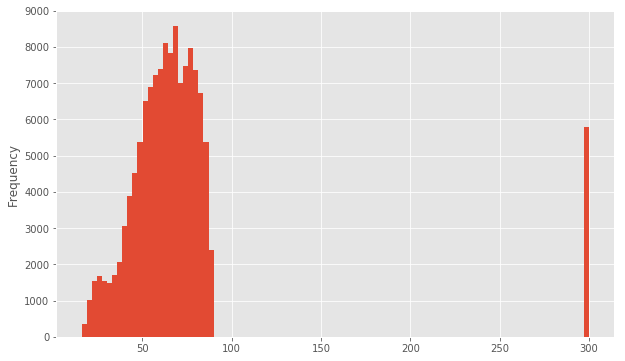

time: 354 ms


In [14]:
len(ABrx_ntnull['icustay_id'].unique())

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
ABrx_16sterile_ntnul['first_admit_age'].sort_values(ascending=True).plot.hist(100)

In [15]:
ABrx_16sterile_ntnul.head()

,Unnamed: 0,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,...,ICU_admit,ICU_disch,los,first_wardid,last_wardid,chartdate,culture_charttime,spec_itemid,spec_type_desc,org_name
0,16,2366833,24915,194424,267059.0,2182-12-10,2182-12-10,MAIN,Daptomycin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
1,842,2366088,24915,194424,267059.0,2182-11-29,2182-12-24,MAIN,Imipenem-Cilastatin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
2,59177,2366064,24915,194424,267059.0,2182-11-17,2182-11-20,MAIN,Vancomycin HCl,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
3,59181,2366065,24915,194424,267059.0,2182-11-17,2182-11-29,MAIN,Imipenem-Cilastatin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
4,60474,2367574,24915,194424,267059.0,2183-01-12,2183-01-15,MAIN,Levofloxacin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None


time: 30.3 ms


### annotating pt who have antibiotics data in cv, mv, or both. 

In [16]:
# updated 4/11/18  
cv_pts= ABrx_16sterile_ntnul[ABrx_16sterile_ntnul['dbsource']=='carevue']['subject_id'].unique()
mv_pts= ABrx_16sterile_ntnul[ABrx_16sterile_ntnul['dbsource']=='metavision']['subject_id'].unique()

both_pts= []
for pt in ABrx_16sterile_ntnul["subject_id"].unique():
    if pt in cv_pts and pt in mv_pts:
        both_pts.append(pt)
        
#need to annotate in pt_db_association column
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'dbsource']=='carevue','pt_ab_db']='cv_ab' 
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'dbsource']=='metavision','pt_ab_db']='mv_ab'
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'dbsource']=='both','pt_ab_db']='both_marking_ab' 
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'subject_id'].isin(both_pts),'pt_ab_db']='cv/mv_ab'


ABrx_16sterile_ntnul_pts = ABrx_16sterile_ntnul.sort_values('startdate').drop_duplicates('subject_id')
ABrx_16sterile_ntnul_pts = ABrx_16sterile_ntnul_pts[['subject_id','Antibiotics','dob','gender','first_admit_age','pt_ab_db']]
#pt_ab_age_df = pd.merge(pt_sterile16_list, ABrx_merged_16sterile_ntnul_pts[['subject_id','pt_ab_db']], left_on= 'subject_id', right_on='subject_id',how = 'inner') 

ABrx_16sterile_ntnul_pts['pt_ab_db'].value_counts() #total: 14903

#numbers before regenerating dataset (filtered for only culture dates within icu date windows -> pt has any sterile culture)
# cv_ab              10394 -> 9639 -> 9629
# mv_ab               9993 -> 9243 -> 9228
# cv/mv_ab             777 -> 684 -> 682
# both_marking_ab       72 -> 72 -> 72
# Name: pt_ab_db, dtype: int64

cv_ab              9658
mv_ab              9247
cv/mv_ab            683
both_marking_ab      72
Name: pt_ab_db, dtype: int64

time: 825 ms


In [17]:
# #saving cv/mv patient annotation
# ABrx_16sterile_ntnul_pts

# date='12102018'

# pd.DataFrame(ABrx_16sterile_ntnul_pts).to_csv("/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_ABrx_16sterile_ntnul_pts.csv" %date) #final cohort database n=11493 subject_id’s (7/6/18)


time: 1.06 ms


### restricting db to only 24hr associated AB and SC
- marking first ab date within 24hr of sterile site culture
- restricting to only rows where the ab's are at or after the first date where an ab is within 24 hour of culture.
- note: the t_end consec is established in the next set to determine consecutive ab days.

In [18]:
def AB_SC_associated_time_annotation(ABrx_16sterile_ntnul):
    
    """
    fxn: annotates antibiotic dataframe with t_0 and t_end for each patient.
    ##t0 is the first ab date in icu associated within 24 hours of sterile site culture
    ##t_end is the longest duration ab associated with t0
    
    input: the merged dataframe consisting of all antibiotic data, hospital, icu admission, and patient data 
    for patients >=16yo w/ a sterile site culture and no null ICUstay_id's (named ABrx_16sterile_ntnul).
    
    output: ABrx_16sterile_ntnul annotated with t_0 and t_end for the FIRST instance of an ab being given in the icu 
    within 24 hours of a sterile site culture. 
    """
    
    #boolean criteria where delta between the AB startdate and culture_charttime is less than 24hr
    lessthan24hr= abs(pd.to_datetime(ABrx_16sterile_ntnul['startdate']) - pd.to_datetime(
        ABrx_16sterile_ntnul['culture_charttime'])) <='24:00:00'

    #column annotating the delta between the AB startdate and culture_charttime is less than 24hr
    ABrx_16sterile_ntnul['ab_culture_delta'] = (
        pd.to_datetime(ABrx_16sterile_ntnul['startdate']) 
        - pd.to_datetime(ABrx_16sterile_ntnul['culture_charttime'])
    )

    #df of all rows where delta between the AB startdate and culture_charttime is less than 24hr
    ABrx_ab24hrdelta= ABrx_16sterile_ntnul.loc[lessthan24hr]
    
    #annotating t_0: the first ab date in icustay associated within 24 hours of sterile site culture
    ABrx_ab24hrdelta['t_0']= ABrx_ab24hrdelta.groupby('icustay_id')['startdate'].transform(lambda x: min(x))

    
    ABrx_16sterile_ptAB24startdate= ABrx_ab24hrdelta[['icustay_id','t_0']].drop_duplicates('icustay_id')

    ABrx_16sterile_ptAB24enddate= ABrx_ab24hrdelta[
        ABrx_ab24hrdelta['startdate']==ABrx_ab24hrdelta[
            't_0']].sort_values(
                ['subject_id','icustay_id','enddate'], ascending=[True,True,False]).drop_duplicates('icustay_id')


    #adding t_0 and t_end to ABrx_16sterile_ntnul by merging w/ AB24startdate and enddate above
    ABrx_16sterile_ntnul= (
        pd.merge(
            ABrx_16sterile_ntnul,
            ABrx_16sterile_ptAB24startdate,
            left_on= 'icustay_id', right_on='icustay_id', how = 'left')
    )
    ABrx_16sterile_ntnul= (
        pd.merge(
            ABrx_16sterile_ntnul,
            ABrx_16sterile_ptAB24enddate[['icustay_id','enddate']],
            left_on= 'icustay_id', right_on='icustay_id', how = 'left')
    )
    #renaming columns for ease
    ABrx_16sterile_ntnul=(
        ABrx_16sterile_ntnul.rename(index=str, columns={'enddate_x':'enddate',"enddate_y":"t_end"})
    )
    return(ABrx_16sterile_ntnul)


def AB_SC_associated_cohort_restriction(ABrx_16sterile_ntnul):
    
    """
    fxn: restrict the input dataframe to only rows where the ab's are at or after the first date where an ab is within 24 hour of culture.
    
    input: the merged dataframe consisting of all antibiotic data, hospital, icu admission, and patient data 
    for patients >=16yo w/ a sterile site culture and no null ICUstay_id's (named ABrx_16sterile_ntnul).
    
    output: ABrx_16sterile_ntnul annotated with t_0 and t_end for the FIRST instance of an ab being given in the icu 
    within 24 hours of a sterile site culture and filtered to only rows where the ab's are at or after the first date where an ab is within 24 hour of culture.
    """
    ABrx_16sterile_ntnul = AB_SC_associated_time_annotation(ABrx_16sterile_ntnul)
    
    ABrx_16sterile_ntnul2=(
        ABrx_16sterile_ntnul.loc[
            ABrx_16sterile_ntnul['startdate'] >= ABrx_16sterile_ntnul['t_0']]
    )
    ABrx_16sterile_ntnul2['t_end_consec']=ABrx_16sterile_ntnul2['t_end']
    ABrx_16sterile_ntnul2['abduration']= (
        pd.to_datetime(ABrx_16sterile_ntnul2['enddate'])
        - pd.to_datetime(ABrx_16sterile_ntnul2['startdate'])
    )

    ABrx_16sterile_ntnul2.sort_values(['subject_id','startdate'])
    return(ABrx_16sterile_ntnul, ABrx_16sterile_ntnul2) #this should be df where all ab_icustart dates are greater than or 
                                  #equal to the first 24 hour associated ab start date after icu admission.

time: 65.1 ms


In [19]:
ABrx_16sterile_ntnul, ABrx_16sterile_ntnul2= AB_SC_associated_cohort_restriction(ABrx_16sterile_ntnul)

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

time: 4.73 s


In [20]:
ABrx_16sterile_ntnul.head()
len(ABrx_16sterile_ntnul)

130880

time: 2.4 ms


In [21]:
len(ABrx_16sterile_ntnul2)

81004

time: 2.97 ms


In [22]:
###Algorithm to squash all dates into a timespan that covers the continuous days on any AB starting at the first ab within 24 hour of a sc
@memory.cache
def update_t_end(t):  
    t.loc[
        ((pd.to_datetime(t['startdate']) <= pd.to_datetime(t['t_end_consec'])) & (
            pd.to_datetime(t['enddate']) >= pd.to_datetime(t['t_end_consec']))),'t_end_consec']= t.loc[
        ((pd.to_datetime(t['startdate']) <= pd.to_datetime(t['t_end_consec'])) & (
            pd.to_datetime(t['enddate']) >= pd.to_datetime(t['t_end_consec']))),'enddate']
    t['t_end_consec']= t.groupby('icustay_id')['t_end_consec'].transform(lambda x: max(x))
    t['abduration']= pd.to_datetime(t['t_end_consec'])-pd.to_datetime(t['t_0'])
    return(t)


time: 10.9 ms


### Calculate and annotate the total continuous time on ANY antibiotic during each patient’s icu stay

In [23]:
def t_end_consec_annotation(ABrx_16sterile_ntnul2):
    """
    input: df, 
    designed for ABrx_16sterile_ntnul2-this should be df where all ab_icustart dates are greater than or equal to the first 24 hour associated ab start date after icu admission.

    output: ABrx_16sterile_ntnul_final, ABrx_16sterile_ntnul_finalPT: the former being all ab's that 
    """
        
    important_columns=[
        'subject_id',
        'icustay_id',
        'hadm_id', #added 8/14/18
        'drug',
        'culture_charttime',
        'ab_culture_delta',
        'startdate',
        'enddate',
        't_0',
        't_end',
        'abduration',
        't_end_consec',
        'ICU_admit',
        'ICU_disch'
    ]
    ABrx_16sterile_ntnul_final= ABrx_16sterile_ntnul2[important_columns].sort_values( 
        ['subject_id',
         'hadm_id', #added 8/14/18
         'icustay_id',
         'startdate',
         'abduration'], ascending=[True,True, True, False, True])  #added another True 8/14/18
    
    #updating t_end consec by running my update_t_end algorithm 5 times. 
    i=1
    while i<6:
        ABrx_16sterile_ntnul_final= update_t_end(ABrx_16sterile_ntnul_final)
        i+=1
    
    #making a final by pt spreadsheet where the first ab prescription meeting the 24hr sc window is listed
    ABrx_16sterile_ntnul_finalPT = ABrx_16sterile_ntnul_final.sort_values(
        ['hadm_id','icustay_id','startdate'], ascending=[True,True,True]).drop_duplicates('hadm_id')  #changed subject_id to hadm_id on 8/14/18
    ABrx_16sterile_ntnul_finalPT = ABrx_16sterile_ntnul_finalPT.sort_values(
        ['hadm_id','icustay_id','startdate'], ascending=[True,True,True]).drop_duplicates('icustay_id')  #changed subject_id to hadm_id on 8/14/18
    
    return(ABrx_16sterile_ntnul_final, ABrx_16sterile_ntnul_finalPT)


time: 20.2 ms


In [24]:
ABrx_16sterile_ntnul_final, ABrx_16sterile_ntnul_finalPT= t_end_consec_annotation(ABrx_16sterile_ntnul2)

time: 9.7 s


count                     15207
mean     5 days 10:25:04.202012
std      5 days 21:11:35.416146
min             0 days 00:00:00
25%             2 days 00:00:00
50%             4 days 00:00:00
75%             7 days 00:00:00
max            97 days 00:00:00
Name: abduration, dtype: object
2 days    2126
1 days    1995
3 days    1993
4 days    1475
5 days    1241
0 days    1092
6 days    1045
7 days     824
Name: abduration, dtype: int64
(7 days 21:51:50.399999, 97 days 00:00:00]    3416
Name: abduration, dtype: int64


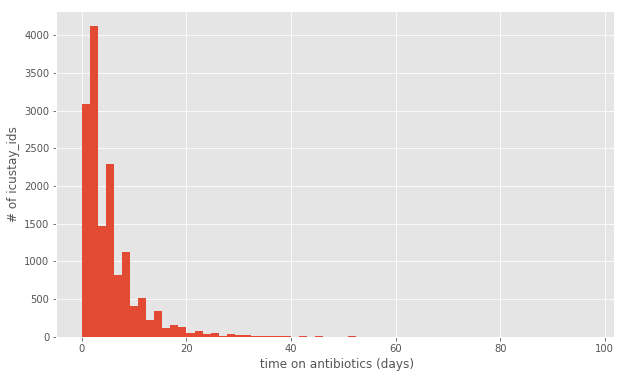

time: 269 ms


In [25]:
#all patients with appropriate antibiotic timing in relation to sterile culture. 
print(ABrx_16sterile_ntnul_finalPT['abduration'].describe())

(ABrx_16sterile_ntnul_finalPT['abduration'] / pd.Timedelta(days=1)).hist(bins = 63)#bins=xrange(min(compare_table['date delta']), 120, 1))
plt.xlabel(' time on antibiotics (days)')
plt.ylabel('# of icustay_ids');

print(ABrx_16sterile_ntnul_finalPT.loc[ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']<= pd.Timedelta(days=7),'abduration'].value_counts())
print(ABrx_16sterile_ntnul_finalPT.loc[ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']> pd.Timedelta(days=7),'abduration'].value_counts(bins=1))
#4/24: n=12613. 
#7/6/18: n=12611

In [26]:
#ABrx_16sterile_ntnul_finalPT.head()
ABrx_16sterile_ntnul_finalPT.loc[:,'hadm_id'].value_counts().describe()

count    15207.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: hadm_id, dtype: float64

time: 11.2 ms


In [27]:
ABrx_16sterile_ntnul_finalPT.loc[:,'icustay_id'].value_counts().describe()

count    15207.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: icustay_id, dtype: float64

time: 12.8 ms


In [28]:
###08/13/2018 some quick qc to respond to nelson, delete

#goal: need to tell how i get from a "by icu_stayid" to a "by patient" final dataframe. where did i choose between them?

time: 1.09 ms


# adding in DOD
we realized later on that we need dod in our spreadsheet. below adds it to our final patient set. 

In [29]:
#task 3, dod
#issue: there is a differential on 155 ssd's. 

#(DOD_HOSP) or the social security database (DOD_SSN).


list_pt =ABrx_16sterile_ntnul_finalPT['subject_id'].unique()
dod_sql = query_schema + """
SELECT subject_id, DOD_HOSP, DOD_SSN 
from mimiciii.patients
WHERE subject_id in {}
""".format(tuple(list_pt))     
dod_df = pd.read_sql_query(dod_sql,conn)

dod_df['delta']= dod_df['dod_hosp']- dod_df['dod_ssn']
#dod_df.loc[dod_df.loc[:,'delta'].notnull()!=timedelta(days=0),:]

dod_df2= dod_df[dod_df['delta'].notnull()]
dod_df2.loc[dod_df2.loc[:,'delta']!= timedelta(days=0),:]

,subject_id,dod_hosp,dod_ssn,delta
224,1339,2140-02-27,2140-02-28,-1 days
280,1748,2188-07-20,2188-07-18,2 days
288,1787,2117-01-14,2117-01-16,-2 days
378,2228,2187-06-20,2187-06-21,-1 days
395,2349,2165-05-16,2165-05-28,-12 days
423,2570,2115-02-20,2115-02-21,-1 days
470,2809,2131-11-23,2131-11-13,10 days
673,3913,2132-08-19,2132-08-27,-8 days
676,3920,2113-01-30,2113-01-27,3 days
751,4276,2109-09-18,2109-09-15,3 days


time: 208 ms


In [30]:
# categorize pt into ab bins

time: 662 µs


In [31]:
#task 4, categorize every patient into ab bins
# group 1= partial= is antibiotics for 3 days or less
# group 2= full= is antibiotics for 5 or more days or died during ab course

ABrx_16sterile_ntnul_finalPT = pd.merge(
    ABrx_16sterile_ntnul_finalPT,
    dod_df[['subject_id','dod_hosp','dod_ssn']],
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

ABrx_16sterile_ntnul_finalPT['ab_course']=''

ABrx_16sterile_ntnul_finalPT.loc[
    ABrx_16sterile_ntnul_finalPT.loc[:,'abduration'] <= pd.Timedelta(days=4),'ab_course']='partial' #days changed from 3 to 4 on 7/16/18 based on Nelson's suggestion

ABrx_16sterile_ntnul_finalPT.loc[
    ABrx_16sterile_ntnul_finalPT.loc[:,'abduration'] >= pd.Timedelta(days=5),'ab_course']='full'

ABrx_16sterile_ntnul_finalPT.loc[
    ((pd.to_datetime(ABrx_16sterile_ntnul_finalPT['t_end_consec'])+ pd.DateOffset(1)) 
     >= pd.to_datetime(ABrx_16sterile_ntnul_finalPT['dod_hosp'])),
    'ab_course']='full'

ABrx_16sterile_ntnul_finalPT.loc[
    ((pd.to_datetime(ABrx_16sterile_ntnul_finalPT['t_end_consec'])+ pd.DateOffset(1)) 
     >= pd.to_datetime(ABrx_16sterile_ntnul_finalPT['dod_ssn'])),
    'ab_course']='full'

print(len(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'ab_course']=='full','subject_id'].unique())) #5485 full patients -> 6188 full on 7/6
print(len(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'ab_course']=='partial','subject_id'].unique())) #5949 partial patients -> 5305 partial on 7/6


6885
6734
time: 77.8 ms


In [32]:
print(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']<= pd.Timedelta(days=7),'abduration'].value_counts())
print(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']>= pd.Timedelta(days=8),'abduration'].value_counts(bins=1))

2 days    2126
1 days    1995
3 days    1993
4 days    1475
5 days    1241
0 days    1092
6 days    1045
7 days     824
Name: abduration, dtype: int64
(7 days 21:51:50.399999, 97 days 00:00:00]    3416
Name: abduration, dtype: int64
time: 19.2 ms


In [33]:
ABrx_16sterile_ntnul_finalPT.loc[ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']== pd.Timedelta(days=0),:]

,subject_id,icustay_id,hadm_id,drug,culture_charttime,ab_culture_delta,startdate,enddate,t_0,t_end,abduration,t_end_consec,ICU_admit,ICU_disch,dod_hosp,dod_ssn,ab_course
5,26773,200853.0,100033,Vancomycin,2194-07-05 21:00:00,0 days 03:00:00,2194-07-06,2194-07-06,2194-07-06,2194-07-06,0 days,2194-07-06,2194-07-05 23:05:38,2194-07-06 21:44:06,NaT,NaT,partial
17,58240,295421.0,100113,Ciprofloxacin HCl,2153-01-05 15:04:00,-1 days +08:56:00,2153-01-05,2153-01-05,2153-01-05,2153-01-05,0 days,2153-01-05,2153-01-05 00:36:39,2153-01-06 15:57:17,NaT,NaT,partial
30,62035,218598.0,100202,CeftriaXONE,2196-07-26 23:30:00,0 days 00:30:00,2196-07-27,2196-07-27,2196-07-27,2196-07-27,0 days,2196-07-27,2196-07-26 23:45:50,2196-07-27 18:50:43,NaT,NaT,partial
38,26401,294278.0,100247,Metronidazole,2144-12-27 21:10:00,0 days 02:50:00,2144-12-28,2144-12-28,2144-12-28,2144-12-28,0 days,2144-12-28,2144-12-27 18:48:50,2145-01-01 11:12:55,NaT,NaT,partial
50,67117,266832.0,100325,Piperacillin-Tazobactam,2135-02-16 12:15:00,0 days 11:45:00,2135-02-17,2135-02-17,2135-02-17,2135-02-17,0 days,2135-02-17,2135-02-16 15:02:09,2135-02-17 16:29:18,NaT,2136-12-27,partial
77,75428,283448.0,100459,Vancomycin,2108-01-25 00:00:00,0 days 00:00:00,2108-01-25,2108-01-25,2108-01-25,2108-01-25,0 days,2108-01-25,2108-01-25 02:37:09,2108-01-25 10:42:19,2108-01-25,NaT,full
86,73289,202228.0,100513,CeftriaXONE,2167-10-30 05:45:00,-1 days +18:15:00,2167-10-30,2167-10-30,2167-10-30,2167-10-30,0 days,2167-10-30,2167-10-30 05:45:24,2167-10-31 16:43:49,NaT,NaT,partial
112,808,239433.0,100677,Vancomycin,2181-07-13 03:33:00,-1 days +20:27:00,2181-07-13,2181-07-13,2181-07-13,2181-07-13,0 days,2181-07-13,2181-07-12 20:12:29,2181-07-13 17:47:11,2182-01-31,2182-01-31,partial
145,7095,227805.0,100931,CefazoLIN,2200-03-07 10:55:00,0 days 13:05:00,2200-03-08,2200-03-08,2200-03-08,2200-03-08,0 days,2200-03-08,2200-03-07 21:18:21,2200-03-08 14:42:09,NaT,2202-10-26,partial
180,29553,257627.0,101085,Cephalexin,2193-11-24 01:13:00,0 days 22:47:00,2193-11-25,2193-11-25,2193-11-25,2193-11-25,0 days,2193-11-25,2193-11-21 10:49:55,2193-11-24 17:31:37,NaT,NaT,partial


time: 58.4 ms


In [34]:
ABrx_16sterile_ntnul_finalPT['icustay_id'].nunique() #12611 subject id's, 12611 icustay id's

15207

time: 3.69 ms


# Extracting Sterile Site Culture results
### accounting for all sterile cultures taken within 48 hours of the first ab. 
4/22/18

In [35]:
#big question to answer, all sterile cultures within 48 hours of what? i am going to set timeframe for each patient: 
#look at all cultures between the first SC within 24 hour of ab and up to 48 hours after first ab dose in ICU.
#this means the max i will cover is 72 hours. 

time: 919 µs


In [36]:
list(ABrx_16sterile_ntnul)
ABrx_16sterile_ntnul['subject_id'].nunique()

19660

time: 6.25 ms


In [37]:


#1) first define the 24 hour associated ab- t_0_sc. 
#2) define 48 hour after the ab- t_end_sc
#filter list of all sterile cultures on the above icustay_id and dates
#record for each icustay_id if any of cultures within the timeframe are positive

#this reuses a lot of the same code used previously in AB_SC_associated_time_annotation. I'm sure this could be optimized/simplified but it works currently. 

def pt_sc_results(ABrx_16sterile_ntnul):

    lessthan24hr= abs(pd.to_datetime(ABrx_16sterile_ntnul['startdate']) - pd.to_datetime(
        ABrx_16sterile_ntnul['culture_charttime'])) <='24:00:00'
    ABrx_ab24hrdelta= ABrx_16sterile_ntnul.loc[lessthan24hr]

    #ABrx_ab24hrdelta['t_0']= ABrx_ab24hrdelta.groupby('icustay_id')['startdate'].transform(lambda x: min(x)) #8/16/18: do i actually need this? haven't i done this already?

    ABrx_ab24hrdelta['t_0_sc']= ABrx_ab24hrdelta.groupby('icustay_id')['culture_charttime'].transform(lambda x: min(x))
    ABrx_ab24hrdelta['t_end_sc']= pd.to_datetime(ABrx_ab24hrdelta['t_0']) + timedelta(days=3) #changed from 2 to 3 on 1/21/19

    #filtering it to only essential info, and only for patients who made it through all other criteria. 
    patients_sc_dates= ABrx_ab24hrdelta[['subject_id','icustay_id','hadm_id','t_0_sc','t_end_sc']].drop_duplicates('icustay_id')
    
    #filtering to only pt in ABrx_16sterile_ntnul_finalPT
    patients_sc_dates= patients_sc_dates.loc[
        patients_sc_dates.loc[:,'icustay_id'].isin(
            list(ABrx_16sterile_ntnul_finalPT['icustay_id'].unique())),:
    ] 
    
    final_pts_all_sc= sterile_pt_df.loc[sterile_pt_df.loc[:,'hadm_id'].isin(list(patients_sc_dates['hadm_id'].unique())),:] 
    final_pts_all_sc= pd.merge(final_pts_all_sc,patients_sc_dates[['hadm_id','t_0_sc','t_end_sc']], left_on= 'hadm_id', right_on='hadm_id', how = 'inner')

    pd.to_datetime(ABrx_16sterile_ntnul['startdate']) - pd.to_datetime(ABrx_16sterile_ntnul['culture_charttime'])

    #all sterile site culture instances between t_0_sc and t_end_sc for patients     
    final_pts_window_sc= final_pts_all_sc[(final_pts_all_sc['charttime']>=final_pts_all_sc['t_0_sc']) &
                    (final_pts_all_sc['charttime']<=final_pts_all_sc['t_end_sc']) &
                    final_pts_all_sc['org_name'].notnull()] 


    positive_organisms= final_pts_all_sc[(final_pts_all_sc['charttime']>=final_pts_all_sc['t_0_sc']) &
                    (final_pts_all_sc['charttime']<=final_pts_all_sc['t_end_sc']) &
                    final_pts_all_sc['org_name'].notnull()]['org_name'].value_counts()
    
    return(patients_sc_dates, final_pts_window_sc, positive_organisms)

time: 44.7 ms


In [38]:
patients_sc_dates, final_pts_window_sc, positive_organisms = pt_sc_results(ABrx_16sterile_ntnul)

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


time: 3.78 s


# SC culture filtering and ab death dose adjust

###  import the annotated culture list, exclude the excludes, and get an # of positives for the staphs.

08/16/18 qc. after chaning the patient criteira, i found that a lot of patients with multiple icustays now have identical culture results. need to explore where this is occuring.




In [39]:
#all sterile site culture instances between t_0_sc and t_end_sc for patients annotated.
#need further processing to make a by patient +/- within t_0_sc and t_end_sc call. 
##details: all staph infections require 2 positive cultures in time window. 
annotated_sc = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/positive_organisms_4-24-18_NSPComments.csv')
#organisms that grew in sc in our patients. annotation key:
#1= eliminate
#0= keep
#2= requires 2 positives in same patient within the timewindow. 
final_pts_window_sc= pd.merge(final_pts_window_sc,annotated_sc[['org_name','Eliminate']], left_on= 'org_name', right_on='org_name', how = 'left')



time: 36 ms


In [40]:
def sc_pos_filter(final_pts_window_sc):
    final_pts_window_sc2= final_pts_window_sc.loc[final_pts_window_sc.loc[:,'Eliminate']==2,:]
    final_pts_window_sc2['concat_col']=(
        final_pts_window_sc2['hadm_id'].map(str) #changed to hadm_id 08/16/2018
        + ' ' 
        + final_pts_window_sc2['org_name'].map(str) 
        + ' ' 
        +  final_pts_window_sc2['chartdate'].map(str)
    )
    final_pts_window_sc3= final_pts_window_sc2.drop_duplicates('concat_col') #n=1603

    test=0
    test = pd.DataFrame(final_pts_window_sc3['hadm_id'].value_counts().reset_index()) #changed  subject_id to hadm_id 08/16/2018
    test.columns = ['hadm_id', 'staph_pos_count'] #changed  subject_id to hadm_id 08/16/2018

    merged = pd.merge(
        final_pts_window_sc,
        test[['hadm_id','staph_pos_count']], #changed  subject_id to hadm_id 08/16/2018
        left_on= 'hadm_id', #changed  subject_id to hadm_id 08/16/2018
        right_on='hadm_id', #changed  subject_id to hadm_id 08/16/2018
        how = 'left')

    criteria1= merged.loc[:,'Eliminate']==0
    criteria2= merged.loc[:,'staph_pos_count']>1
    merged= merged[criteria1|criteria2]
    merged= merged[merged['Eliminate']!=1]
    return(merged)

final_pts_window_pos_sc = sc_pos_filter(final_pts_window_sc) #31108 #all sc for patients with any positives.
final_pts_window_pos_sc_list= list(final_pts_window_pos_sc['hadm_id'].unique()) #changed to hadm_id 08/16/2018
#len(final_pts_window_pos_sc_list) #2630. 

time: 146 ms


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
final_pts_window_pos_sc.loc[final_pts_window_pos_sc.loc[:,'staph_pos_count']>2,:].head()
#hadm_id 183885 has positive staph

,row_id,subject_id,hadm_id,chartdate,charttime,spec_itemid,spec_type_desc,org_name,t_0_sc,t_end_sc,Eliminate,staph_pos_count
6365,139396,10361,195393,2177-12-18,2177-12-18 04:45:00,70012,BLOOD CULTURE,ENTEROBACTERIACEAE,2177-12-18 04:45:00,2177-12-21,0.0,3.0
6366,139397,10361,195393,2177-12-18,2177-12-18 04:45:00,70012,BLOOD CULTURE,ENTEROBACTERIACEAE,2177-12-18 04:45:00,2177-12-21,0.0,3.0
6367,139398,10361,195393,2177-12-18,2177-12-18 04:45:00,70012,BLOOD CULTURE,ENTEROBACTERIACEAE,2177-12-18 04:45:00,2177-12-21,0.0,3.0
6368,139399,10361,195393,2177-12-18,2177-12-18 04:45:00,70012,BLOOD CULTURE,ENTEROBACTERIACEAE,2177-12-18 04:45:00,2177-12-21,0.0,3.0
6369,139400,10361,195393,2177-12-18,2177-12-18 04:45:00,70012,BLOOD CULTURE,ENTEROBACTERIACEAE,2177-12-18 04:45:00,2177-12-21,0.0,3.0


time: 24.6 ms


### make list of all patients positive, negative sc cultures

In [42]:
#5/2/18, makes list of all pos culture result and specimen types for annotation on final df
def sc_pos_filter2(final_pts_window_sc):
    final_pts_window_sc['concat_col']=(
        final_pts_window_sc['hadm_id'].map(str)  #changed to hadm_id 08/16/2018
        + ' ' 
        + final_pts_window_sc['org_name'].map(str) 
        + ' ' 
        +  final_pts_window_sc['chartdate'].map(str)
    )
    final_pts_window_sc2= final_pts_window_sc.drop_duplicates('concat_col') #n=1603

    return(final_pts_window_sc2)

final_pts_window_pos_sc2 = sc_pos_filter2(final_pts_window_pos_sc) #31108 #all sc for patients with any positives.
#organism name
final_pts_window_pos_sc3 = final_pts_window_pos_sc2.groupby('hadm_id')['org_name'].apply(', '.join).reset_index() #changed to hadm_id from subject_id 08/16/2018
final_pts_window_pos_sc3 = final_pts_window_pos_sc3.rename(index=str, columns={'org_name':'org_list'})

#specimen type
final_pts_window_pos_sc4 = final_pts_window_pos_sc2.groupby('hadm_id')['spec_type_desc'].apply(', '.join).reset_index() #changed to hadm_id from subject_id 08/16/2018
final_pts_window_pos_sc4 = final_pts_window_pos_sc4.rename(index=str, columns={'spec_type_desc':'spec_type_list'})

#now have a column with all positive culture results and specimen types


time: 806 ms


In [43]:
len(patients_sc_dates)

15207

time: 2.88 ms


# FINAL cohort generation
08/16/18 qc. after chaning the patient criteira, i found that a lot of patients with multiple icustays now have identical culture results. need to explore where this is occuring.

1) make final ab categorizations
2) make final patient list with ab, sterile site culture results and final binning

In [44]:
#4/30/18: ASSEMBLING A FINAL PT LIST. 
#final_pts_window_pos_sc_list= list(final_pts_window_pos_sc['subject_id'].unique())
final_pt_df = patients_sc_dates

final_pt_df = pd.merge(
    final_pt_df,
    ABrx_16sterile_ntnul_finalPT[['icustay_id','ab_course', 't_0','t_end_consec','ICU_admit']], #testing the ICU_admit with this
    left_on= 'icustay_id', #changed from subject_id
    right_on='icustay_id',
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    dod_df2,
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    final_pts_window_pos_sc3,
    left_on= 'hadm_id', #changed to hadm_id from subject_id 08/16/18
    right_on='hadm_id', #changed to hadm_id from subject_id 08/16/18
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    final_pts_window_pos_sc4,
    left_on= 'hadm_id', #changed to hadm_id from subject_id 08/16/18
    right_on='hadm_id', #changed to hadm_id from subject_id 08/16/18
    how = 'left')

final_pt_df= final_pt_df.rename(index=str, columns={'delta':'dod_delta'})
final_pt_df['sc_result']=''
final_pt_df['final_bin']=''

#task 1, marking of all patients positive, negative sc cultures
final_pt_df.loc[final_pt_df.loc[:,'hadm_id'].isin(final_pts_window_pos_sc_list),'sc_result']='positive' #changed to hadm_id from subject_id 08/16/18
final_pt_df.loc[final_pt_df.loc[:,'sc_result']!='positive','sc_result']='negative'
#1 is positive, 0 is negative

#FINAL_PT_LIST=list(final_pt_df['subject_id'].unique())
final_pt_df.loc[(final_pt_df['ab_course']=='partial') 
                   & (final_pt_df['sc_result']=='negative'),'final_bin']='C_neg/A_partial'
final_pt_df.loc[(final_pt_df['ab_course']=='full') 
                   & (final_pt_df['sc_result']=='negative'),'final_bin']='C_neg/A_full'
final_pt_df.loc[(final_pt_df['ab_course']=='full') 
                   & (final_pt_df['sc_result']=='positive'),'final_bin']='C_pos/A_full'
final_pt_df.loc[(final_pt_df['ab_course']=='partial') 
                   & (final_pt_df['sc_result']=='positive'),'final_bin']='C_pos/A_partial'

#len(list(final_pts_window_pos_sc['subject_id'].unique())) #2630

final_pt_df
final_pt_df2= final_pt_df.loc[final_pt_df.loc[:,'ab_course']!='',:] 
#this is final patient dataframe with 11434 patients with following criteria:
#antibiotic in PRESCRIPTION table within 24 hours of an sterile site culture in MICROBIOLOGYEVENTS table
#who are over the age of 16. the culture result (annotated below) and antibiotic course (annotated below) are 
#also annotated on this. these patients were then categorized into 4 categories:
# 'C_neg/A_partial'
# 'C_neg/A_full'
# 'C_pos/A_full'
# 'C_pos/A_partial'
# notes:
# 1)i considered any patient who had their last antibiotic date at or after either 
#hospital or ssn DOD as "full" ab course. 

# 2) i considered any patients who had the listed staph infections positive at 
#any of their sterile site cultures within the 72hour ab timewindow as a culture 'positive' patients. 


#pd.DataFrame(final_pt_df2).to_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/06072018_final_pt_df2.csv')


time: 184 ms


In [45]:
final_pt_df2['icustay_id'].nunique()

15207

time: 8.57 ms


In [46]:
print(final_pt_df2['final_bin'].value_counts())#11493

C_neg/A_partial    6000
C_neg/A_full       5546
C_pos/A_full       2127
C_pos/A_partial    1534
Name: final_bin, dtype: int64
time: 16.7 ms


# cohort generated above

dr luo request:

It would also be good to add the start and end time for the antibiotics. --DONE


Dr. Nelson request:

 1)provide an extra column with the DOD. --DONE
 
 2)one with the first positive culture results (the actual value, as in “Enteroccous Faecalis”, etc.) for those with positive cultures, 
 
 3)the type of culture (eg. urine, blood, etc.).

In [47]:
# #5/15/18 to do, regenerate this for our cohort to get count of sterile site cultures. 
# #breakdown the 1345 pts cultures, 
# #if a patient has multiple culture types within 24 hr peroid, would be nice to know which are +/-. 
# #more informative to know if pt was ever pos for bloodculture.

# #Look at distribution of all cultures within the 24 hour mark. 

# %pylab inline
# pylab.rcParams['figure.figsize'] = (10, 6)
# sterile_test_df.spec_type_desc.value_counts().head(20).sort_values(ascending=True).plot.barh()

time: 5.66 ms


In [48]:
#qc 8/16/18, delete after this
final_pt_df2.loc[final_pt_df2.loc[:,'icustay_id']==220988.0,:].sort_values(['t_0','hadm_id','icustay_id'])



,subject_id,icustay_id,hadm_id,t_0_sc,t_end_sc,ab_course,t_0,t_end_consec,ICU_admit,dod_hosp,dod_ssn,dod_delta,org_list,spec_type_list,sc_result,final_bin
2322,31942,220988.0,196809,2125-08-03 07:00:00,2125-08-06,partial,2125-08-03,2125-08-07,2125-08-03 07:45:42,NaT,NaT,NaT,NaN,NaN,negative,C_neg/A_partial


time: 28.8 ms


# compiling the dataframes into csv's

In [49]:
date='16082018'

pd.DataFrame(final_pt_df2).to_csv("/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_final_pt_df2.csv" %date) #final cohort database n=11493 subject_id’s (7/6/18)


time: 257 ms


style guide stuff:
    
79 characters is longest a line should be, this is 79 chars:
Address the unique rows issue in the sterile culture. Need to use this to filkter down the staph.

In [50]:
#last instance of ICU_admit time. 

time: 774 µs


In [51]:
#final_pt_df2

time: 411 µs


In [52]:
(pd.to_datetime(final_pt_df2['ICU_admit'])-pd.to_datetime(final_pt_df2['t_0'])).describe()

count                       15207
mean     -1 days +10:28:18.628986
std        2 days 05:11:22.892182
min            -77 days +13:52:53
25%             -1 days +14:59:35
50%             -1 days +20:45:15
75%        0 days 01:52:10.500000
max               0 days 11:59:39
dtype: object

time: 23 ms


In [53]:
final_pt_df2['admit_vs_t_0']= (pd.to_datetime(final_pt_df2['ICU_admit'])-pd.to_datetime(final_pt_df2['t_0']))

time: 10.1 ms


In [54]:
final_pt_df2['admit_vs_t_0_td']=final_pt_df2['admit_vs_t_0'].astype(np.timedelta64)

time: 6.78 ms


In [55]:
final_pt_df2.sort_values('admit_vs_t_0_td')

final_pt_df2[final_pt_df2['admit_vs_t_0_td']<-1e+14].sort_values('admit_vs_t_0_td')['subject_id'].nunique() #3519/11488 patients have a delta of greater than 2 days of their icustay



1957

time: 23 ms
